In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Viewing an image
from IPython.display import Image
Image('/kaggle/input/fruits-dataset-images/images/apple fruit/Image_1.jpg')

In [6]:
import os
fruit_names = os.listdir('/kaggle/input/fruits-dataset-images/images')

In [9]:
filename = []
labels = []
for i in fruit_names:
    for j in os.listdir('/kaggle/input/fruits-dataset-images/images/' + i):
        filename.append('/kaggle/input/fruits-dataset-images/images/' + i + '/' + j)
        labels.append(i)

In [12]:
lbl_unique = np.unique(labels)
lbl_unique

array(['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit',
       'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit',
       'strawberry fruit'], dtype='<U16')

In [14]:
boolean_labels = [lbl == lbl_unique for lbl in labels]

In [15]:
X = filename
Y = boolean_labels

In [16]:
NUM_IMAGES = 1000

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val = train_test_split(X[:NUM_IMAGES],Y[:NUM_IMAGES],test_size = 0.2)

In [18]:
# Convert image to numpy
from matplotlib.pyplot import imread
img = imread(filename[200])

In [20]:
IMG_SIZE = 224
def process_image(image_path):
    image = tf.io.read_file(image_path)
  # turn jpeg into numerical tensor
    image = tf.image.decode_jpeg(image,channels = 3)
      # Converting the color channel values from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image,tf.float32)
      # Resize the image to (244,244)
    image = tf.image.resize(image,size = [IMG_SIZE,IMG_SIZE])
    return image


In [21]:
# Create a function to return a tuple (image,label)
def get_image_label(image,label):
    image = process_image(image)
    return image,label

In [22]:
# Function to turn all our data into (x,y)
BATCH_SIZE = 32
def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
    if test_data:
    # In case of test data we dont have labels.
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
        databatch = data.map(process_image).batch(BATCH_SIZE)
        return databatch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        databatch = data.map(get_image_label).batch(BATCH_SIZE)
        return databatch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
        # Shuffling pathname & labels
        data = data.shuffle(buffer_size = len(x))
        data = data.map(get_image_label).batch(BATCH_SIZE)
        return data

In [23]:
# Create Training and Validation data batches
train_data = create_data_batches(X_train,Y_train)
val_data = create_data_batches(X_val,Y_val,valid_data = True)

In [27]:
def show_25_images(images,labels):
    plt.figure(figsize = (10,10))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(lbl_unique[labels[i].argmax()])
        plt.axis("off")

In [28]:
train_images,train_labels = next(train_data.as_numpy_iterator())

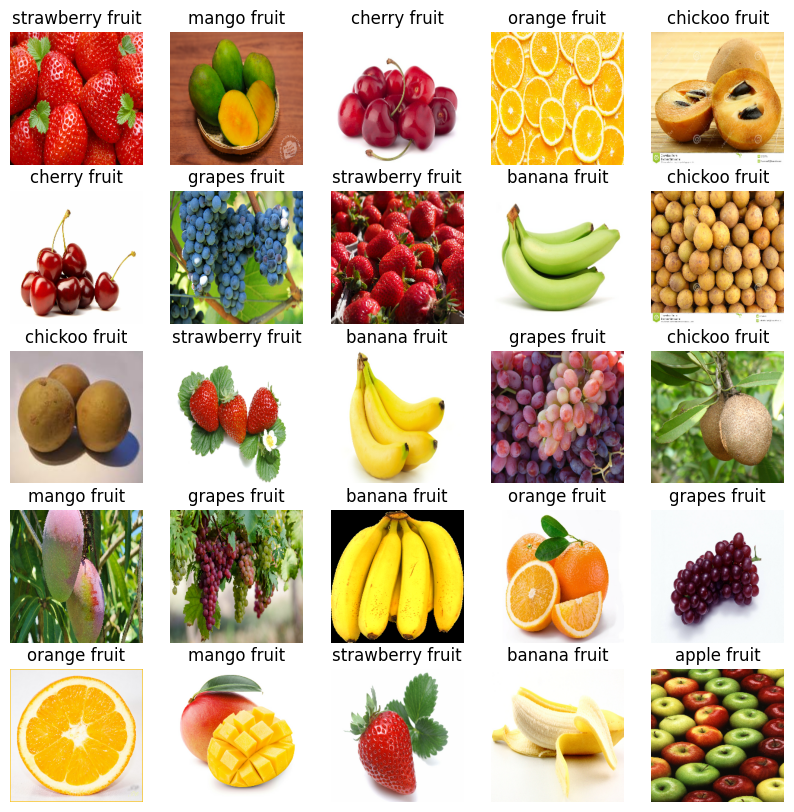

In [29]:
show_25_images(train_images,train_labels)

In [31]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
OUTPUT_SHAPE = len(lbl_unique)
MODEL_URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'

In [32]:
def create_model(input_shape = INPUT_SHAPE,output_shape = OUTPUT_SHAPE,model_url = MODEL_URL):
    print("Building a Model with url :",model_url)
    print(input_shape,output_shape)
    # Setting up the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units = output_shape,activation = 'softmax')
    ])
    # Compiling the model
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(),
        metrics = ['accuracy']
    )
    # Build the model
    model.build(input_shape)
    return model

In [33]:
model = create_model()
model.summary()


Building a Model with url : https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
[None, 224, 224, 3] 9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              3540265   
                                                                 
 dense (Dense)               (None, 9)                 9018      
                                                                 
Total params: 3,549,283
Trainable params: 9,018
Non-trainable params: 3,540,265
_________________________________________________________________


In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy',patience = 3)

In [35]:
NUM_EPOCHS = 100

In [37]:
def train_model():
    model = create_model()
    tensorboard = create_tensorboard_callback()
    model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard,early_stopping])
    return model

In [40]:
import datetime,os
def create_tensorboard_callback():
    logdir = os.path.join('/content/drive/MyDrive/dog-breed-classification/logs/',datetime.datetime.now().strftime('%y-%m-%d %H:%M:%S'))
    return tf.keras.callbacks.TensorBoard(logdir)

In [41]:
model = train_model()

Building a Model with url : https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4
[None, 224, 224, 3] 9
Epoch 1/100
9/9 [==============================] - 14s 1s/step - loss: 2.2834 - accuracy: 0.2847 - val_loss: 1.3048 - val_accuracy: 0.6111
Epoch 2/100
9/9 [==============================] - 9s 939ms/step - loss: 0.7979 - accuracy: 0.7361 - val_loss: 0.6839 - val_accuracy: 0.8333
Epoch 3/100
9/9 [==============================] - 9s 986ms/step - loss: 0.3467 - accuracy: 0.9062 - val_loss: 0.5206 - val_accuracy: 0.8889
Epoch 4/100
9/9 [==============================] - 9s 949ms/step - loss: 0.1907 - accuracy: 0.9549 - val_loss: 0.4694 - val_accuracy: 0.9028
Epoch 5/100
9/9 [==============================] - 10s 1s/step - loss: 0.1244 - accuracy: 0.9896 - val_loss: 0.4644 - val_accuracy: 0.8889
Epoch 6/100
9/9 [==============================] - 10s 1s/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 0.4491 - val_accuracy: 0.8889
Epoch 7/100
9/9 [==========================

In [42]:
predictions = model.predict(val_data,verbose = 1)

3/3 [==============================] - 2s 264ms/step


In [43]:
def unbatchify(data):
    images_ = []
    labels_ = []
    for image,label in data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(label)
    return images_,labels_

In [47]:
def get_pred_labels(pred_prob):
    return lbl_unique[np.argmax(pred_prob)]

In [48]:
val_images,val_labels = unbatchify(val_data)

In [49]:
get_pred_labels(val_labels[0])

'apple fruit'

In [50]:
def plot_pred(pred_prob,labels,images,n=1):
    pred_probs,true_label,image_pred = pred_prob[n],labels[n],images[n]
    pred_lbl = get_pred_labels(pred_probs)
    true_lbl = get_pred_labels(true_label)
    color = ''
    if pred_lbl == true_lbl:
        color = 'green'
    else:
        color = 'red'
    plt.imshow(image_pred)
    plt.xticks([])
    plt.yticks([])
    plt.title("{} {:2.0f}% {}".format(pred_lbl,np.max(pred_probs)*100,true_lbl),color = color)

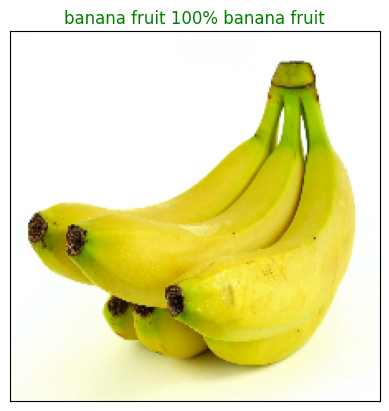

In [52]:
plot_pred(predictions,val_labels,val_images,2)

In [54]:
# Saving and loading the model
def save_model(model,suffix = None):
    model_dir = os.path.join('/kaggle/working/models/',
                           datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    modelpath = model_dir + '-' + suffix + '.h5'
    print("Model is being saved at :",model_dir)
    model.save(modelpath)
    return modelpath

In [55]:
save_model(model,'1000-images-mobilenetv2')

Model is being saved at : /kaggle/working/models/20231108-163724


'/kaggle/working/models/20231108-163724-1000-images-mobilenetv2.h5'

In [60]:
loaded_model = load_model('/kaggle/working/models/20231108-163724-1000-images-mobilenetv2.h5')

Loading saved model from: /kaggle/working/models/20231108-163724-1000-images-mobilenetv2.h5


In [59]:
def load_model(model_path):
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
    return model

In [61]:
model.evaluate(val_data)

3/3 [==============================] - 2s 254ms/step - loss: 0.4495 - accuracy: 0.8750


[0.4495267868041992, 0.875]

In [62]:
# Training the model on the entire dataset
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size = 0.2)

In [ ]:
train_data = create_data_batches(X_train,Y_train)
val_data = create_data_batches(X_val,Y_val,valid_data = True)

In [ ]:
load_full_saved_model = load_model('')

In [63]:
accuracy = load_full_saved_model.evaluate(val_data)

NameError: name 'load_full_saved_model' is not defined

In [ ]:
print(f"The accuracy of the model : {accuracy[1]*100}%")

In [ ]:
# Making predictions on the test data
test_images = ['/content/drive/MyDrive/dog-breed-classification/test/' + dir for dir in os.listdir('/content/drive/MyDrive/dog-breed-classification/test')]

In [ ]:
test_data = create_data_batches(test_images,test_data = True)

In [ ]:
test_images_predictions = load_fulL_saved_model.predict(test_data,verbose=1)

In [ ]:
label_of_test_image_predictions = [get_pred_labels(pred) for pred in test_images_predictions]

In [ ]:
# Now we want our model to predict result on any new image that it encounters
new_img = ['dog2.jpg']
new_img = create_data_batches(new_img,test_data = True)
get_pred_labels(load_full_saved_model.predict(new_img,verbose = 16))

In [ ]:
show_img = plt.imread('dog2.jpg')
plt.imshow(show_img)